In [1]:
# import libraries

import os
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import shap
import optuna
from optuna.integration import LightGBMPruningCallback
from typing import List, Dict
from pathlib import Path

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

/Users/felixdiaz/opt/anaconda3/envs/lgb-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in files

folderpath = '../data/data_frames/'
paths = Path(folderpath).glob('team*.csv')
pathlist = list(paths)

# data formatting

data = pd.concat(map(pd.read_csv, pathlist), ignore_index=True)
data['latitude'] = data['row']
data['longitude'] = data['col']
data['team'] = data['team_icecon']
data['visual'] = data['visual_ice'] / (data['visual_ice'] + data['ocean_fraction'])
data['distance_from_land'] = data['edtl']
data["error"] = data["team"] - data["visual"]
data = data.dropna()

# stratified random sampling (SRS) (200 values x 101 levels = 20200 points)

data['bin'] = (data['visual'] * 100).round().astype(int)
data['bin2'] = (data['visual'] * 100).round().astype(int)

stratified = (data
    .groupby('bin2', group_keys=False)
    .apply(lambda g: g.sample(min(200, len(g)), random_state=42), include_groups=False)
    .reset_index(drop=True)
)

data = stratified[["error",
               "team",
               "visual",
               "latitude",
               "longitude",
               "distance_from_land",
               "ocean_fraction",
               "land_fraction",
               "snow_fraction",
               "sun_elevation",
               "cloud_cover"]]
print(stratified)

       Unnamed: 0        time  row  col  crs  team_icecon  bootstrap_icecon  \
0        25523907  2019-07-07  184   67  b''        0.056             0.000   
1        37370204  2016-10-01  176   92  b''        0.000             0.000   
2        22115147  2024-06-11  171   59  b''        0.000             0.000   
3        37407692  2013-10-02  299  188  b''        0.000             0.000   
4        27568928  2016-07-21  191   80  b''        0.000             0.000   
...           ...         ...  ...  ...  ...          ...               ...   
20195     9077863  2017-03-08  293  119  b''        1.000             1.000   
20196     9359070  2019-03-10  322  126  b''        1.000             1.000   
20197    16541732  2014-05-02  205  180  b''        0.736             0.921   
20198    13152952  2019-04-07  258   88  b''        1.000             1.000   
20199     9993568  2021-03-15  169  176  b''        0.960             1.000   

           edtl  visual_ice  ocean_fraction  ...  c

In [3]:
# Prepare data + feature list

features = [
    "visual", 
    "distance_from_land",
    "ocean_fraction", 
    "land_fraction", 
    "snow_fraction", 
    "sun_elevation",
    "cloud_cover"
]
target = "error"
df = data.copy()

print(df.head(10))

      error   team    visual  latitude  longitude  distance_from_land  \
0  0.056000  0.056  0.000000       184         67            1.000000   
1  0.000000  0.000  0.000000       176         92            1.000000   
2  0.000000  0.000  0.000000       171         59            4.000000   
3  0.000000  0.000  0.000000       299        188            6.082763   
4 -0.000001  0.000  0.000001       191         80            5.385165   
5 -0.000128  0.000  0.000128       257         74            0.000000   
6  0.000000  0.000  0.000000       276        255            2.000000   
7  0.000000  0.000  0.000000       279        112            2.000000   
8  0.000000  0.000  0.000000       308        105            1.000000   
9  0.000000  0.000  0.000000       278        257            1.000000   

   ocean_fraction  land_fraction  snow_fraction  sun_elevation  cloud_cover  
0        1.000000       0.000000       0.000000      45.272524         0.01  
1        1.000000       0.000000       0

In [4]:
# Create lgb.Dataset, inspect with .construct(), and save binary

X = df[features]
y = df[target].values

# Path to save dataset binary
dataset_binary_path = "lgb_dataset.bin"

# Construct once; reuse if saved
if os.path.exists(dataset_binary_path):
    # load dataset
    lgb_train_dataset = lgb.Dataset(dataset_binary_path)
else:
    lgb_train_dataset = lgb.Dataset(
        data=X,
        label=y,
        free_raw_data=False
    )

    lgb_train_dataset.construct()

    # Save to binary for reuse (skips re-binning next time)

    lgb_train_dataset.save_binary(dataset_binary_path)
    

[LightGBM] [Info] Saving data to binary file lgb_dataset.bin


In [ ]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 16, 1024),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "max_bin": trial.suggest_int("max_bin", 64, 1024),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
        "seed": RANDOM_SEED,
        "force_col_wise": True
    }

    cv_folds = 3
    cv_results = lgb.cv(
        params=param,
        train_set=lgb_train_dataset,
        folds=KFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED),
        num_boost_round=500,
        seed=RANDOM_SEED,
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            LightGBMPruningCallback(trial, "rmse"),
            lgb.log_evaluation(period=0)
        ]
    )

    # Dynamically find the correct RMSE key
    metric_key = [k for k in cv_results.keys() if "rmse-mean" in k or "valid" in k][0]
    best_rmse = min(cv_results[metric_key])
    
    return best_rmse

# Create and run study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=50, n_jobs=1)

print("Best params from Optuna:", study.best_params)

best_params = study.best_params
best_params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": RANDOM_SEED
})


In [6]:
# Train final model using KFold holdouts & capture performance / early stopping

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

rmse_list, mae_list, r2_list = [], [], []
models = []
best_iter_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dtrain = lgb.Dataset(
        X_train, label=y_train, free_raw_data=True
    )
    dvalid = lgb.Dataset(
        X_val, label=y_val, free_raw_data=True
    )

    # Train with callbacks for early stopping (LightGBM >=4.0)
    booster = lgb.train(
        params=best_params,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)  # suppress iteration logs
        ]
    )

    models.append(booster)
    best_iter_list.append(booster.best_iteration)

    # Predict & compute metrics
    y_pred = booster.predict(X_val, num_iteration=booster.best_iteration)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"Fold {fold}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

print("CV results (mean ± std):")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE:  {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R2:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	train's rmse: 0.105827	valid's rmse: 0.208036
Fold 1: RMSE=0.2080, MAE=0.1557, R2=0.5034
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	train's rmse: 0.0911425	valid's rmse: 0.214947
Fold 2: RMSE=0.2149, MAE=0.1617, R2=0.4936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	train's rmse: 0.120293	valid's rmse: 0.207158
Fold 3: RMSE=0.2072, MAE=0.1563, R2=0.4979
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[341]	train's rmse: 0.107732	valid's rmse: 0.213342
Fold 4: RMSE=0.2133, MAE=0.1607, R2=0.5051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[536]	train's rmse: 0.0867293	valid's rmse: 0.21076
Fold 5: RMSE=0.2108, MAE=0.1585, R2=0.4827
CV results (mean ± std):
RMSE: 0.2108 ±

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

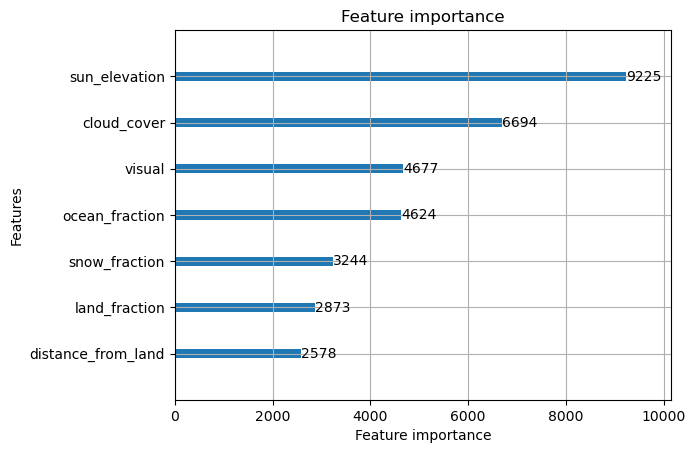

In [7]:
lgb.plot_importance(models[0], max_num_features=20)

In [8]:
# Train final booster on full dataset
final_train = lgb.Dataset(X, label=y, free_raw_data=True)
final_booster = lgb.train(
    params=best_params,
    train_set=final_train,
    num_boost_round=2000,
    callbacks=[
        lgb.log_evaluation(period=50)  # optional: prints every 50 rounds
    ]
)

# Save final model and Optuna study
final_booster.save_model("lgb_final_model.txt")
joblib.dump(study, "optuna_study.pkl")

['optuna_study.pkl']

In [9]:
# Gain & split

importance_gain = final_booster.feature_importance(importance_type="gain")
importance_split = final_booster.feature_importance(importance_type="split")

importance_df = pd.DataFrame({
    "feature": final_booster.feature_name(),  # note the ()
    "importance_gain": importance_gain,
    "importance_split": importance_split
}).sort_values("importance_gain", ascending=False).reset_index(drop=True)
importance_df.to_csv('./importance_values.csv')
print(importance_df)


              feature  importance_gain  importance_split
0       sun_elevation      1752.262697             47385
1         cloud_cover      1009.191813             33008
2              visual       970.185064             33069
3       snow_fraction       767.358043             18112
4      ocean_fraction       594.523454             30208
5  distance_from_land       418.596042             15948
6       land_fraction       356.954318             12270


In [10]:
# SHAP values: compute mean absolute and mean signed (direction)

# Sample subset
shap_sample_n = min(10000, len(X))
X_shap = X.sample(shap_sample_n, random_state=RANDOM_SEED)

explainer = shap.TreeExplainer(final_booster)
shap_values = explainer.shap_values(X_shap)  # shape: (n_rows, n_features)

shap_mean_abs = np.abs(shap_values).mean(axis=0)
shap_mean_signed = shap_values.mean(axis=0)

shap_df = pd.DataFrame({
    "feature": X_shap.columns,
    "shap_mean_abs": shap_mean_abs,
    "shap_mean_signed": shap_mean_signed
}).sort_values("shap_mean_abs", ascending=False).reset_index(drop=True)
print(shap_df)
shap_df.to_csv('./shap_values.csv')

              feature  shap_mean_abs  shap_mean_signed
0              visual       0.097179          0.003022
1       sun_elevation       0.096383         -0.004143
2         cloud_cover       0.069835          0.002006
3       snow_fraction       0.067480          0.002772
4  distance_from_land       0.038859         -0.001346
5      ocean_fraction       0.033690         -0.002033
6       land_fraction       0.031323          0.002851
